In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from bd_datagen import generate_collocation_points, generate_interface_collocation_points
from bd_ffe import FourierFeatureEmbedding
from bd_physicsandloss_fns import pde_loss, bc_loss, interface_loss, flexural_rigidity, normalise, denormalise
from bd_beamnet import BeamNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

if device.type == 'cpu':
    torch.set_num_threads(16)
    print(f"Limiting cpu threads to: {torch.get_num_threads()}")

Using cpu
Limiting cpu threads to: 16


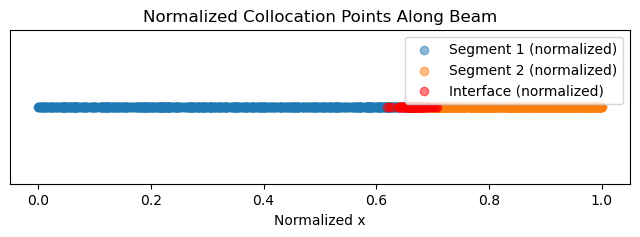

In [2]:
# data generation

n_collocation = 1000
n_interface = 100
x_ranges = [(0,2), (2,3)]
interface_x = 2.0
interface_width = 0.05  #how tightly the interface points are clustered

x1,x2 = generate_collocation_points(n_collocation, x_ranges)
interface_points = generate_interface_collocation_points(0, n_interface, x_ranges, interface_x, interface_width)[-1]


x_all = [x1, x2, interface_points]
xmin, xmax = 0.0, 3.0
x_all_norm = [normalise(x, xmin, xmax) for x in x_all]
x1,x2, xs_interface = x_all_norm

x1_flat = x1.flatten()
x2_flat = x2.flatten()
xs_interface_flat = xs_interface.flatten()

# Convert to torch tensors and enable gradients#
x1 = x1.reshape(-1, 1)
x2 = x2.reshape(-1, 1)
xs_interface = xs_interface.reshape(-1, 1)

x1_torch = torch.from_numpy(x1).to(torch.float32).to(device).requires_grad_(True)
x2_torch = torch.from_numpy(x2).to(torch.float32).to(device).requires_grad_(True)
xs_interface_torch = torch.from_numpy(xs_interface).to(torch.float32).to(device).requires_grad_(True)

x_all_torch = torch.cat([x1_torch, x2_torch, xs_interface_torch], dim=0)

plt.figure(figsize=(8, 2))
plt.scatter(x1_flat, np.zeros_like(x1_flat), alpha=0.5, label='Segment 1 (normalized)')
plt.scatter(x2_flat, np.zeros_like(x2_flat), alpha=0.5, label='Segment 2 (normalized)')
plt.scatter(xs_interface_flat, np.zeros_like(xs_interface_flat), alpha=0.5, label='Interface (normalized)', color='red')
plt.xlabel('Normalized x')
plt.yticks([])
plt.title('Normalized Collocation Points Along Beam')
plt.legend()
plt.show()


# for use in the pde loss calculation
xs_interface_1 = xs_interface[xs_interface <= interface_x]
xs_interface_2 = xs_interface[xs_interface > interface_x]

xs_interface_1_torch = torch.from_numpy(xs_interface_1).to(torch.float32).to(device).requires_grad_(True)
xs_interface_2_torch = torch.from_numpy(xs_interface_2).to(torch.float32).to(device).requires_grad_(True)

xs_interface_1_torch = xs_interface_1_torch.reshape(-1,1)
xs_interface_2_torch = xs_interface_2_torch.reshape(-1,1)

# Concatenate with segment points
x1_all_torch = torch.cat([x1_torch, xs_interface_1_torch], dim=0)
x2_all_torch = torch.cat([x2_torch, xs_interface_2_torch], dim=0)   #ie an array for each segment including all collocation points

Epoch 0: Total Loss 2.2386e+10 | PDE 3.3926e-02 | BC 2.7160e+06 | IF 2.2359e+07
Epoch 100: Total Loss 9.5802e+04 | PDE 2.0538e-03 | BC 2.0943e+01 | IF 9.5593e+01
Epoch 200: Total Loss 6.1862e+00 | PDE 2.0708e-03 | BC 2.4017e-04 | IF 6.1817e-03
Epoch 300: Total Loss 2.9186e-03 | PDE 2.0707e-03 | BC 7.4114e-05 | IF 1.0669e-07
Epoch 400: Total Loss 2.8988e-03 | PDE 2.0707e-03 | BC 7.4020e-05 | IF 8.7824e-08
Epoch 500: Total Loss 2.8111e-03 | PDE 2.0707e-03 | BC 7.4016e-05 | IF 2.2927e-10
Epoch 600: Total Loss 2.8111e-03 | PDE 2.0707e-03 | BC 7.4013e-05 | IF 2.2927e-10
Epoch 700: Total Loss 3.0270e-03 | PDE 2.0707e-03 | BC 7.4013e-05 | IF 2.1611e-07
Epoch 800: Total Loss 2.8110e-03 | PDE 2.0707e-03 | BC 7.4006e-05 | IF 2.2927e-10
Epoch 900: Total Loss 2.8273e-03 | PDE 2.0707e-03 | BC 7.4025e-05 | IF 1.6339e-08


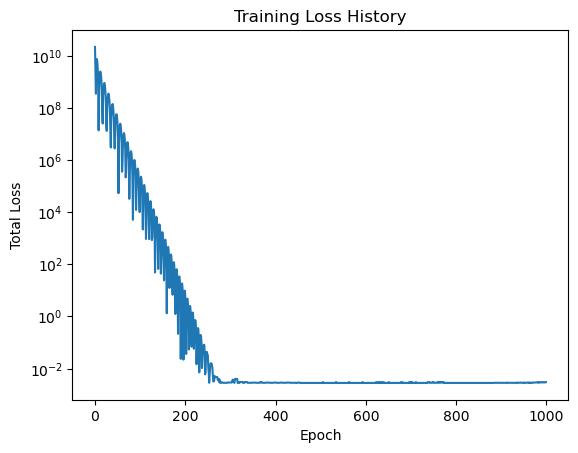

In [3]:
#instantiate the model and plot the losses wrt epochs

model =  BeamNet(input_dim=1, output_dim=2,
                 n_units=40, n_layers=4,
                 pde_weight=1.0, bc_weight=10.0, if_weight=1000.0,
                 use_ffe=False, num_frequencies=4, fourier_scale=1.0).to(device)

losses = model.fit(x1_all_torch, x2_all_torch, xmin=0.0, xmax=3.0, epochs=1000, lr=0.001)



plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss History')
plt.show()

torch.Size([500, 1])
x_norm shape: (500,)
w_true shape: (500,)
pinn_output shape: (500, 2)
w_pinn shape: (500,)


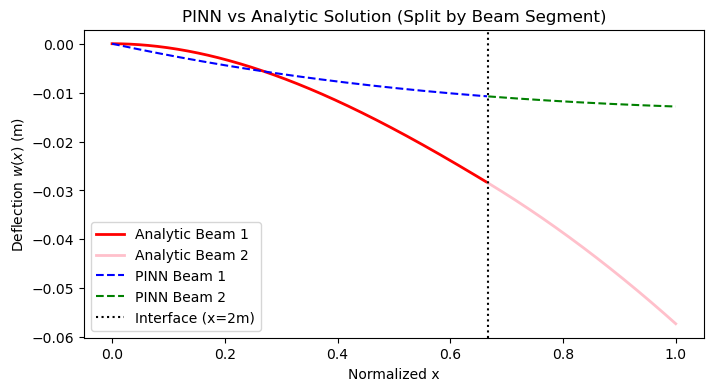

w_at_2m: -0.028455893317255693, w_at_3m: -0.057264201151357726


In [4]:
# Generate a dense set of normalized x values
#x_plot = np.linspace(0, 1, 500).reshape(-1, 1).astype(np.float32)
##x_plot_torch = torch.from_numpy(x_plot).to(torch.float32).to(device)

# Get model predictions
#model.eval()
#with torch.no_grad():
#    w_pred = model(x_plot_torch).cpu().numpy().flatten()


#=======================================================================================
# Copy and pasted from chatgpt
#==========================================================================================

import numpy as np
import matplotlib.pyplot as plt
import torch

# 1. Beam and material properties
E1, D1 = 210e9, 0.05
E2, D2 = 180e9, 0.04
I1 = np.pi/64 * D1**4
I2 = np.pi/64 * D2**4
EI1 = E1 * I1
EI2 = E2 * I2

# 2. Solve for analytic solution coefficients
A = np.zeros((5, 5))
b = np.zeros(5)

# Unknowns: [c1, d1, a2, b2, c2]
A[0, 0] = 4      # c1
A[0, 1] = 8      # d1
A[0, 2] = -1     # a2
A[0, 3] = -2     # b2
A[0, 4] = -4     # c2
b[0] = 0

A[1, 0] = 4      # c1
A[1, 1] = 12     # d1
A[1, 3] = -1     # b2
A[1, 4] = -4     # c2
b[1] = 0

A[2, 0] = 2*EI1
A[2, 1] = 12*EI1
A[2, 4] = -2*EI2
b[2] = 0

A[3, 1] = -6*EI1
b[3] = -500

A[4, 4] = 2*EI2
b[4] = -250

sol = np.linalg.solve(A, b)
c1, d1, a2, b2, c2 = sol

def w_analytic(x):
    w = np.zeros_like(x)
    mask1 = x < 2
    mask2 = x >= 2
    w[mask1] = c1 * x[mask1]**2 + d1 * x[mask1]**3
    w[mask2] = a2 + b2 * x[mask2] + c2 * x[mask2]**2
    return w

# Generate x values and normalize
x_min, x_max = 0.0, 3.0
x_phys = np.linspace(0, 3, 500)
x_norm = (x_phys - x_min) / (x_max - x_min)

# Evaluate analytic solution
w_true = w_analytic(x_phys)

# Evaluate PINN prediction on the SAME x_norm points
x_norm_torch = torch.from_numpy(x_norm.reshape(-1, 1)).to(torch.float32).to(next(model.parameters()).device)
print(x_norm_torch.shape)
model.eval()
with torch.no_grad():
    pinn_output = model(x_norm_torch).cpu().numpy()
    w_pinn = pinn_output[:, 0]

# Define the interface in normalized coordinates
interface_phys = 2.0
interface_norm = (interface_phys - x_min) / (x_max - x_min)

# Create masks for each segment
mask1 = x_norm < interface_norm
mask2 = x_norm >= interface_norm

print("x_norm shape:", x_norm.shape)
print("w_true shape:", w_true.shape)
print("pinn_output shape:", pinn_output.shape)
print("w_pinn shape:", w_pinn.shape)



# Plot
plt.figure(figsize=(8, 4))
plt.plot(x_norm[mask1], w_true[mask1], color='r', linewidth=2, label='Analytic Beam 1')
plt.plot(x_norm[mask2], w_true[mask2], color='pink', linewidth=2, label='Analytic Beam 2')
plt.plot(x_norm[mask1], w_pinn[mask1], '--', color='b', label='PINN Beam 1')
plt.plot(x_norm[mask2], w_pinn[mask2], '--', color='g', label='PINN Beam 2')
plt.axvline(interface_norm, color='k', linestyle=':', label='Interface (x=2m)')
plt.xlabel('Normalized x')
plt.ylabel('Deflection $w(x)$ (m)')
plt.title('PINN vs Analytic Solution (Split by Beam Segment)')
plt.legend()
plt.show()

# Define the physical x values to evaluate
x_at_2m = 2.0
x_at_3m = 3.0

# Evaluate the analytic solution at these specific x values
# Pass them as a NumPy array to match the w_analytic function's expected input
w_at_2m = w_analytic(np.array([x_at_2m]))[0] # [0] to get the scalar value from the array
w_at_3m = w_analytic(np.array([x_at_3m]))[0]

print(f"w_at_2m: {w_at_2m}, w_at_3m: {w_at_3m}")

#================================================================================
#================================================================================

##plt.figure(figsize=(8, 4))
#plt.plot(x_plot, w_pred, label='Predicted $w(x)$')
#plt.xlabel('Normalized x')
#plt.ylabel('Deflection $w(x)$')
#plt.title('PINN Predicted Beam Deflection')
#plt.legend()
#plt.show()